In [1]:
import numpy as np
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import pandas as pd
from Model import Model
from PlaceInputs import PlaceInputs
from utils import *
import configs

# Initialize RNN

In [2]:
import matplotlib as mpl
mpl.rcParams['figure.dpi'] = 300

In [3]:
# Parameters
N_inp = 5000
N_bar = 5000
num_states = 100

In [4]:
place_inputs = PlaceInputs(N_inp, num_states).get_inputs()
model = Model(
    N_inp, N_bar, num_states,
    #plasticity_bias = -0.45,
    narrow_search_factor=0.5, wide_search_factor=1.5,
    )
unskewed_J = model.J_xx.copy()

In [5]:
cache_state = 50

In [15]:
cache_unit = (cache_state/num_states)*N_inp

# Learning without skew

In [6]:
identification_s = 0.

Now I just cached at location: 50


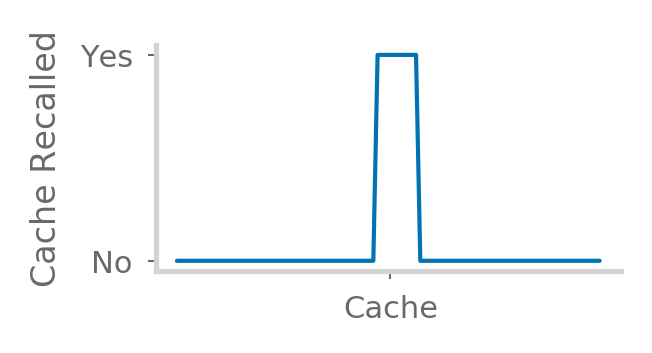

In [21]:
model.reset()
model.J_xx = unskewed_J.copy()

_, place_acts, _, _ = model.run_nonrecurrent(place_inputs)
    
print("Now I just cached at location:", cache_state)
preacts, acts, _, acts_over_time = model.run_recurrent(place_inputs)
model.update(place_inputs[cache_state], acts[cache_state], preacts[cache_state])

_, _, _cache_identification, _ = model.run_recall(identification_s, place_inputs)
cache_presence = np.linalg.norm(_cache_identification, axis=1)
cache_presence /= cache_presence.max()
cache_locs = _cache_identification.argmax(axis=1)
unbiased_readout = np.logical_and(
    cache_presence>0.5, cache_locs==cache_unit
    )

plt.figure(figsize=(2,1))
plt.plot(unbiased_readout)
plt.xticks([cache_state], ['Cache'])
plt.ylabel('Cache Recalled')
plt.yticks([0,1], ['No', 'Yes'])
plt.show()

# Influencing recall via adjustment of predictive component

### Add predictive skew to RNN weights

In [22]:
model.reset()
model.J_xx = unskewed_J.copy()

In [23]:
identity = np.eye(model.N_bar)
total_delta = np.zeros((model.N_bar, model.N_bar))
n_shifts = 1000
offset = 50
gamma = 0.965
for s in range(1, n_shifts):
    shifted = np.roll(identity, shift=-(s+offset), axis=0)
    delta = (gamma**s)*shifted*0.25
    total_delta += delta.copy()
model.J_xx[:,int(0.2*5000):int(0.5*5000)] += total_delta[:, int(0.2*5000):int(0.5*5000)]

### Learning with skew

Now I just cached at location: 50


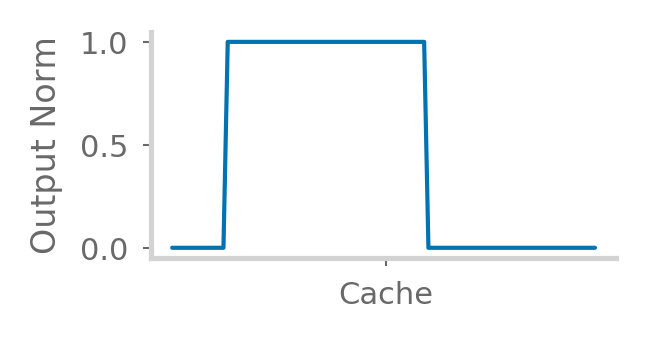

In [24]:
_, pred_place_acts, _, _ = model.run_nonrecurrent(place_inputs)
    
print("Now I just cached at location:", cache_state)
preacts, acts, _, acts_over_time = model.run_recurrent(place_inputs)
model.update(place_inputs[cache_state], acts[cache_state], preacts[cache_state])

_, _, _cache_identification, _ = model.run_recall(identification_s, place_inputs)

cache_presence = np.linalg.norm(_cache_identification, axis=1)
cache_presence /= cache_presence.max()
cache_locs = _cache_identification.argmax(axis=1)
pred_readout = np.logical_and(
    cache_presence>0.5, cache_locs==cache_unit
    )

plt.figure(figsize=(2,1))
plt.plot(pred_readout)
plt.xticks([cache_state], ['Cache'])
plt.ylabel('Output Norm')
plt.show()

### Plotting the before and afters

<Figure size 1800x1200 with 0 Axes>

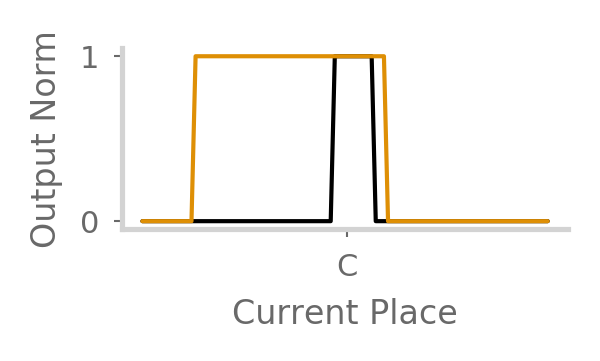

In [25]:
plt.figure()
plt.figure(figsize=(2.1, 1.25))
plt.plot(unbiased_readout, color='black')
plt.plot(pred_readout, color='C1')
plt.xticks([cache_state], ['C'])
plt.ylabel('Output Norm')
plt.xlabel('Current Place')
plt.yticks([0, 1])
plt.tight_layout()
plt.show()

# Influencing recall via recurrent strength (doesn't work)

### Add predictive skew to RNN weights

In [15]:
model.reset()
model.J_xx = unskewed_J.copy()

In [16]:
identity = np.eye(model.N_bar)
total_delta = np.zeros((model.N_bar, model.N_bar))
n_shifts = 1000
offset = 50
gamma = 0.965
for s in range(1, n_shifts):
    shifted = np.roll(identity, shift=-(s+offset), axis=0)
    delta = (gamma**s)*shifted*0.2
    total_delta += delta.copy()
model.J_xx[:,int(0.2*5000):int(0.5*5000)] += total_delta[:, int(0.2*5000):int(0.5*5000)]

### Learning with skew across different recurrent strengths

Now I just cached at location: 50


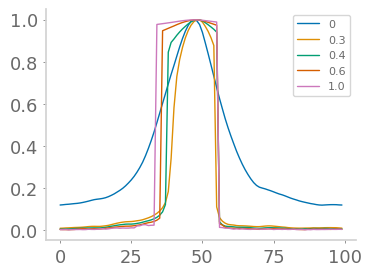

In [17]:
print("Now I just cached at location:", cache_state)
preacts, acts, _, acts_over_time = model.run_recurrent(place_inputs, n_zero_input=20)
model.update(place_inputs[cache_state], acts[cache_state], preacts[cache_state])

rec_strengths = [0, 0.3, 0.4, 0.6, 1.0]
fig, ax = plt.subplots(figsize=(4,3))
for rec_strength in rec_strengths:
    _, _, _cache_identification, _ = model.run_recall(
        identification_s, place_inputs, rec_strength=rec_strength)
    readout = np.linalg.norm(_cache_identification, axis=1)
    readout /= readout.max()
    ax.plot(readout, label=rec_strength)
plt.legend()
plt.show()